<a href="https://colab.research.google.com/github/mjgonzalezGUD/TFM_denoising_transformers/blob/main/N2V_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# N2V Prediction
Please run the 'N2V-Convallaria-1-Training' notebook first.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/project_folder/pn2v-master/unet')
sys.path.append('/content/drive/MyDrive/project_folder/pn2v-master/pn2v')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from model import UNet
from utils import denormalize
from utils import normalize
from utils import PSNR
import utils
import prediction
import training
import histNoiseModel

# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

In [ ]:

path = '/content/drive/MyDrive/project_folder/pn2v-master/data/BSD68_reproducibility_data/'
# Load the training data
dataTest= np.load(path+'test/bsd68_gaussian25.npy', allow_pickle=True)
dataTest.shape
# We estimate the ground truth by averaging.
dataTestGT= np.load(path+'test/bsd68_groundtruth.npy', allow_pickle=True)
dataTestGT.shape

(68,)

###Load Data Convallaria

In [ ]:
from tifffile import imread
# We need the training data in order to calulate 'mean' and 'std' for normalization
path='/content/drive/MyDrive/project_folder/pn2v-master/Convallaria_diaphragm/'

# Load the test data
dataTest=imread(path+"20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif")[:,:512,:512]
# We are loading only a sub image to spped up computation

# We estimate the ground truth by averaging.
dataTestGT=np.mean(dataTest[:,...],axis=0)[np.newaxis,...]

In [ ]:
dataTest

array([[[ 565,  540,  476, ...,  598,  832, 1318],
        [ 673,  691,  611, ...,  595,  654, 1227],
        [ 503,  503,  587, ...,  504,  679, 1058],
        ...,
        [ 589,  660,  500, ...,  510,  691,  627],
        [ 534,  509,  701, ...,  614,  664,  607],
        [ 562,  646,  637, ...,  714,  615,  760]],

       [[ 501,  455,  508, ...,  576,  738, 1059],
        [ 486,  563,  509, ...,  664,  632, 1146],
        [ 685,  710,  540, ...,  763,  642, 1020],
        ...,
        [ 660,  679,  718, ...,  583,  540,  557],
        [ 551,  544,  820, ...,  721,  576,  537],
        [ 608,  451,  592, ...,  710,  751,  559]],

       [[ 463,  588,  570, ...,  572,  884, 1279],
        [ 447,  593,  478, ...,  596,  975,  920],
        [ 522,  604,  535, ...,  558,  858,  761],
        ...,
        [ 674,  808,  862, ...,  608,  532,  562],
        [ 527,  766,  799, ...,  549,  564,  824],
        [ 742,  832,  461, ...,  696,  778,  716]],

       ...,

       [[ 485,  508,  51

In [ ]:
# Load the network, created in the 'Convallaria-2-Training' notebook
net=torch.load(path+"/N2V/last_conv_N2V.net")

image: 0
PSNR input 29.009240856174337
PSNR N2V 35.88448266401491
-----------------------------------
image: 1
PSNR input 29.018589127299936
PSNR N2V 35.835696574447596
-----------------------------------
image: 2
PSNR input 29.035458856560645
PSNR N2V 35.85597127688426
-----------------------------------
image: 3
PSNR input 28.990347509982925
PSNR N2V 35.86954675956157
-----------------------------------
image: 4
PSNR input 29.002852113680238
PSNR N2V 35.866994413793854
-----------------------------------
image: 5
PSNR input 29.02402327393454
PSNR N2V 35.85703178356076
-----------------------------------
image: 6
PSNR input 29.032053580418268
PSNR N2V 35.907748009891954
-----------------------------------
image: 7
PSNR input 29.017435705343363
PSNR N2V 35.87676009052902
-----------------------------------
image: 8
PSNR input 29.003677692102134
PSNR N2V 35.92658925530732
-----------------------------------
image: 9
PSNR input 28.991348421709475
PSNR N2V 35.87967283319729
--------------

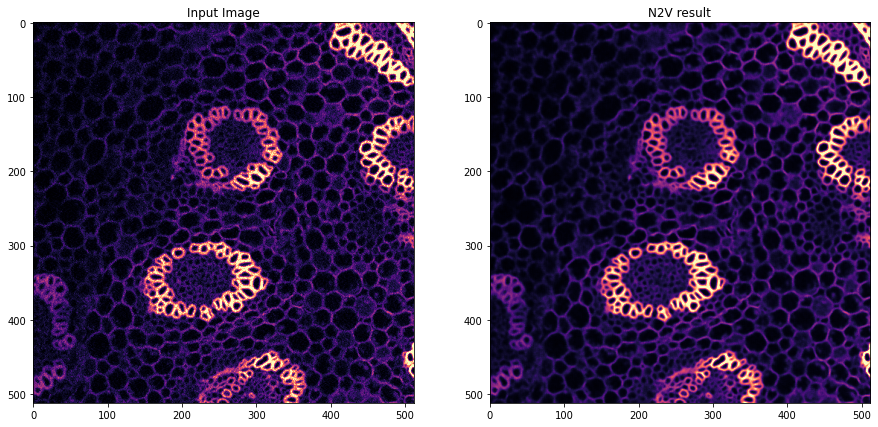

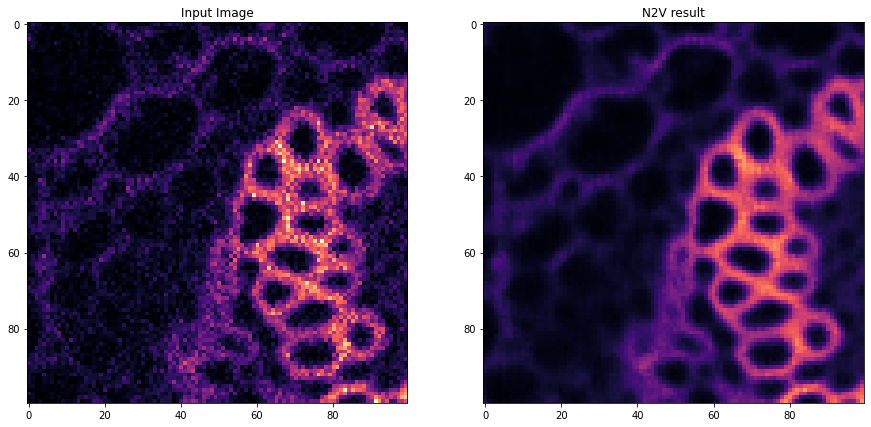

Avg PSNR: 35.87577823084256 +-(2SEM) 0.007327843287281444


In [ ]:
# Now we are processing data and calculating PSNR values.
n2vRes=[]
resultImgs=[]
inputImgs=[]

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    
    im=dataTest[index]
    gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    n2vResult = prediction.tiledPredict(im, net ,ps=256, overlap=48,
                                            device=device, noiseModel=None)
    
    
    inputImgs.append(im)

    rangePSNR=np.max(gt)-np.min(gt)
    n2vPrior=PSNR(gt, n2vResult,rangePSNR )
    n2vRes.append(n2vPrior)

    print ("image:",index)
    print ("PSNR input",PSNR(gt, im, rangePSNR))
    print ("PSNR N2V",n2vPrior) # Without info from masked pixel
    print ('-----------------------------------')
    
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 2, 2)
plt.title(label='N2V result')
plt.imshow(n2vResult, vmax=vma, vmin=vmi, cmap='magma')

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 2, 2)
plt.title(label='N2V result')
plt.imshow(n2vResult[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
plt.show()

print("Avg PSNR:", np.mean(np.array(n2vRes) ), '+-(2SEM)',2*np.std(np.array(n2vRes) )/np.sqrt(float(len(n2vRes)) ) )

### Load the Network

In [ ]:
# Load the network, created in the 'Convallaria-2-Training' notebook
net=torch.load(path+"train/last_conv_N2V.net")

### Evaluation

image: 1
PSNR input 20.19402651962569
PSNR N2V 28.66845448913541
-----------------------------------
image: 2
PSNR input 20.19402651962569
PSNR N2V 25.044000371202447
-----------------------------------
image: 3
PSNR input 20.19402651962569
PSNR N2V 24.578230922005417
-----------------------------------
image: 4
PSNR input 20.19402651962569
PSNR N2V 30.63665000918369
-----------------------------------
image: 5
PSNR input 20.19402651962569
PSNR N2V 20.05820911688687
-----------------------------------
image: 6
PSNR input 20.19402651962569
PSNR N2V 20.825941746160414
-----------------------------------
image: 7
PSNR input 20.19402651962569
PSNR N2V 28.377663272923467
-----------------------------------
image: 8
PSNR input 20.19402651962569
PSNR N2V 30.172384581696846
-----------------------------------
image: 9
PSNR input 20.19402651962569
PSNR N2V 24.974761595296805
-----------------------------------
image: 10
PSNR input 20.19402651962569
PSNR N2V 30.49680396101252
-------------------

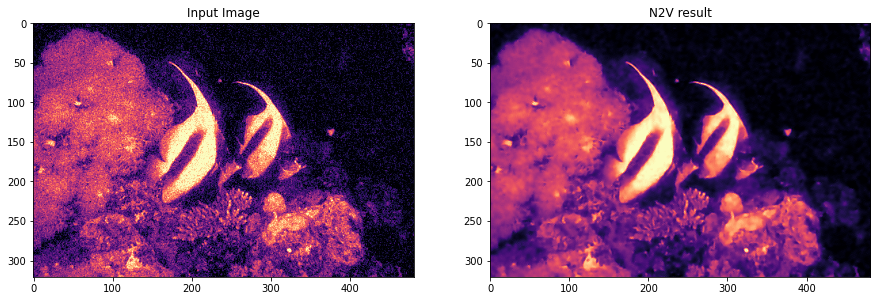

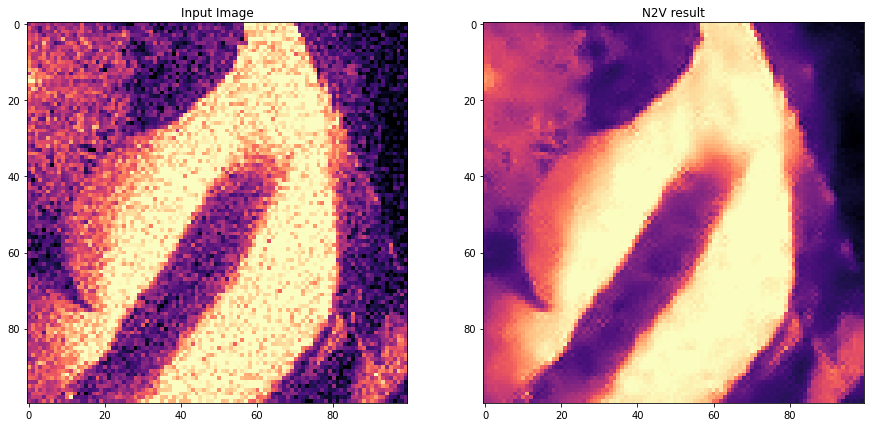

Avg PSNR: 26.518760880422292 +-(2SEM) 0.6359109776783856


In [ ]:
# Now we are processing data and calculating PSNR values.
n2vRes=[]
resultImgs=[]
inputImgs=[]
index = 1
# We iterate over all test images.

for gt, im in zip(dataTestGT, dataTest): 

    #im=dataTest[index]
    #gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    n2vResult = prediction.tiledPredict(im, net ,ps=256, overlap=48,
                                            device=device, noiseModel=None)
    
    
    inputImgs.append(im)

    rangePSNR=255.0
    n2vPrior=PSNR(gt, n2vResult,rangePSNR )
    n2vRes.append(n2vPrior)

    print ("image:",index)
    print ("PSNR input",PSNR(gt, im, rangePSNR))
    print ("PSNR N2V",n2vPrior) # Without info from masked pixel
    print ('-----------------------------------')
    index +=1
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 2, 2)
plt.title(label='N2V result')
plt.imshow(n2vResult, vmax=vma, vmin=vmi, cmap='magma')

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 2, 2)
plt.title(label='N2V result')
plt.imshow(n2vResult[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
plt.show()

print("Avg PSNR:", np.mean(np.array(n2vRes) ), '+-(2SEM)',2*np.std(np.array(n2vRes) )/np.sqrt(float(len(n2vRes)) ) )